# Simple Linear Regression 
Exploration and pracice for running linear regressions, checking and graphing errors and building functions

## Libraries & Functions

In [547]:
 #library imports 
import pandas as pd  
#pip install pandasql
import pandasql
import numpy as np  

from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm 
import statsmodels.stats.api as sms
import scipy.stats as stats 
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns   
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

In [548]:
#data distribution   
def kde(xs): 
    """Takes in a dataframe specifice column id slr_df["sqft_living"] 
        Returns a KDE Graph"""
    #xs.plot.kde()
    #plt.title("distribution check for dependent and independent variable")
    #plt.show() 
    xs.plot.hist(density=True, label = 'histogram')
    xs.plot.kde(label = 'kde')
    plt.legend()
    plt.show()

In [549]:
def plot_regression(df, x, y, xs, ys): 
    """takes in: 
    df = dataframe
    x = dependent feature 
    y = independent feature (outcome/target)
    xs = dataframe defined column ie slr_df["sqft_living"]
    ys = dataframe defined column ie slr+df["price"]
    
    returns:  
    slope, 
    best fit 
    scatter plot with regression line
    """
    #calculate the slope of the line
    mx = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) / ((np.mean(xs)**2) - np.mean(xs*xs))) 
    
    #calculate the best fit of the line
    c = np.mean(ys) - m*np.mean(xs) 
    
    regression_line = [(m*x)+c for x in xs] 
    
    plt.scatter(xs,ys,color='#003F72', label="Data points")
    plt.plot(xs, regression_line, label= "Regression Line")
    plt.legend() 
  
    print("\n") 
    print("Slope:", round(m,2)) 
    print("\n") 
    print("Best Fit:", round(m, 2), round(c,2)) 

In [550]:
def ols_and_error_vis(df, x, y, xs, ys):   
    """takes in: 
    df = dataframe
    x = dependent feature 
    y = independent feature (outcome/target)
    xs = dataframe defined column ie slr_df["sqft_living"]
    ys = dataframe defined column ie slr+df["price"]n 
    
    Returns: OlS summary and a error plot""" 
    
    #fit model 
    predictors = '+'.join(x_cols) 
    formula = outcome + "~" + predictors
    model = ols(formula=formula, data=df).fit()  
    
    #plot errors
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
    plt.show() 
    
    print(model.summary())

In [551]:
def qqplot(df, x, y, xs, ys):   
    """takes in: 
    df = dataframe
    x = dependent feature 
    y = independent feature (outcome/target)
    xs = dataframe defined column ie slr_df["sqft_living"]
    ys = dataframe defined column ie slr+df["price"]n 
    
    Returns: a qqplot""" 
    
    #fit model 
    predictors = '+'.join(x_cols) 
    formula = outcome + "~" + predictors
    model = ols(formula=formula, data=df).fit()   
    
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    fig.show()  

In [552]:
def test(df, x, y, xs, ys):   
    """ 
    A JB value of roughly 6 or higher indicates that errors are not normally distributed. 
    
    The GQ test checks if you can define a point that can be used to differentiate the variance of the error term.
    
    takes in: 
    df = dataframe
    x = dependent feature 
    y = independent feature (outcome/target)
    xs = dataframe defined column ie slr_df["sqft_living"]
    ys = dataframe defined column ie slr+df["price"]n 
    
    Returns: 
    JB Test  
    """ 
    
    #fit model 
    predictors = '+'.join(x_cols) 
    formula = outcome + "~" + predictors
    model = ols(formula=formula, data=df).fit()   
    
    #JB Test
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(model.resid) 
    
    print(list(zip(name, test)))

## Data Import and Preprocessing

In [553]:
%store -r df

In [554]:
slr_df = df.copy()

In [555]:
#leave just the month date column
slr_df['month'] =slr_df['date'].dt.month
slr_df = slr_df.drop(['date', "id"], axis=1) 

In [556]:
slr_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2


In [557]:
#remove outliers beyond 2 std for the mean
z = np.abs(stats.zscore(slr_df)) 
threshold = 3 #3 std away from them mean
print(np.where(z > 3))

(array([    1,     5,     5, ..., 21574, 21574, 21584], dtype=int64), array([13,  2,  3, ..., 11, 17, 10], dtype=int64))


In [558]:
slr_df = slr_df[(z<3).all(axis=1)]

In [559]:
slr_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2
6,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,0.0,1995,0.0,98003,47.3097,-122.327,2238,6819,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,5
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,2
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,6
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,1


In [560]:
#train & test groups
train, test = train_test_split(slr_df) 
print("Train:", len(train), "Test:", len(test))

Train: 14131 Test: 4711


## Price vs Bedrooms

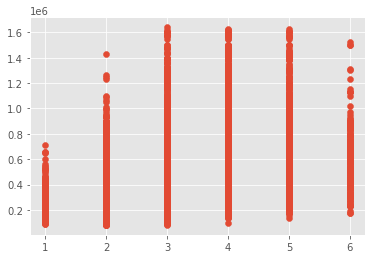

In [561]:
plt.scatter(slr_df['bedrooms'], slr_df['price']) 

In [562]:
#Investigate the relationship further in EDA

## Price vs Bathrooms

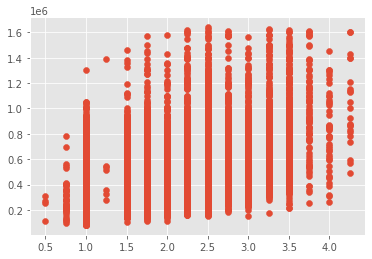

In [563]:
plt.scatter(slr_df['bathrooms'], slr_df['price']) 

In [564]:
#Investigate the relationship further in EDA

## Price vs Sqft_living



Slope: 355430.6


Best Fit: 355430.6 -692736164.64


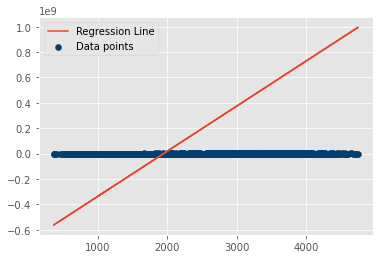

In [565]:
#simple regression
plot_regression(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"])

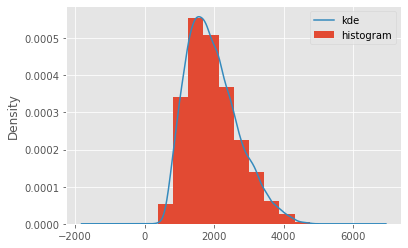

In [566]:
kde(slr_df['sqft_living'])

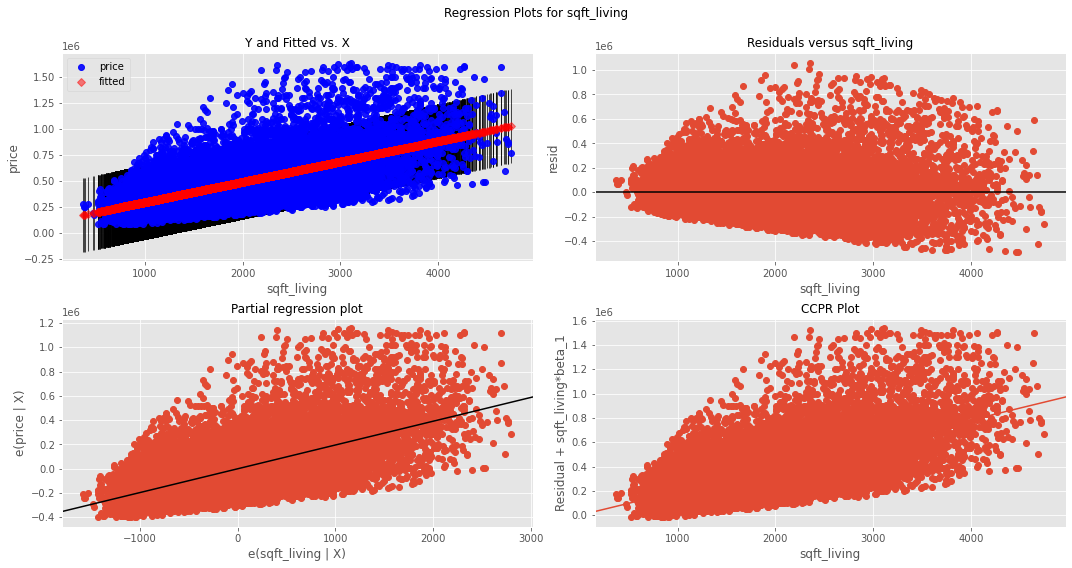

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.192e+04
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        03:43:26   Log-Likelihood:            -2.5493e+05
No. Observations:               18842   AIC:                         5.099e+05
Df Residuals:                   18840   BIC:                         5.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.001e+05   3738.658     26.787      

In [567]:
ols_and_error_vis(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"])

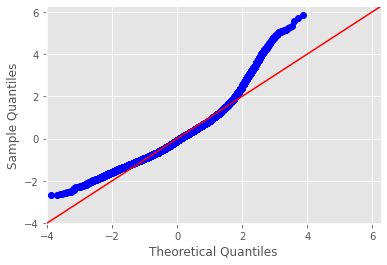

In [568]:
qqplot(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"])

## Price vs sqft_lot



Slope: 355430.6


Best Fit: 355430.6 -3490766620.4


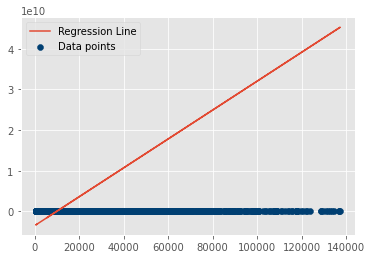

In [569]:
plot_regression(df=slr_df, x="sqft_lot", y="price", xs=slr_df["sqft_lot"], ys=slr_df["price"])

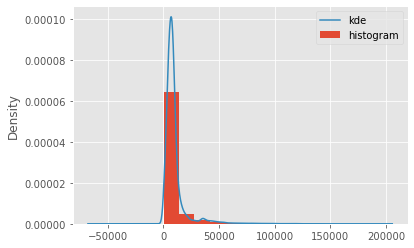

In [570]:
kde(slr_df['sqft_lot'])

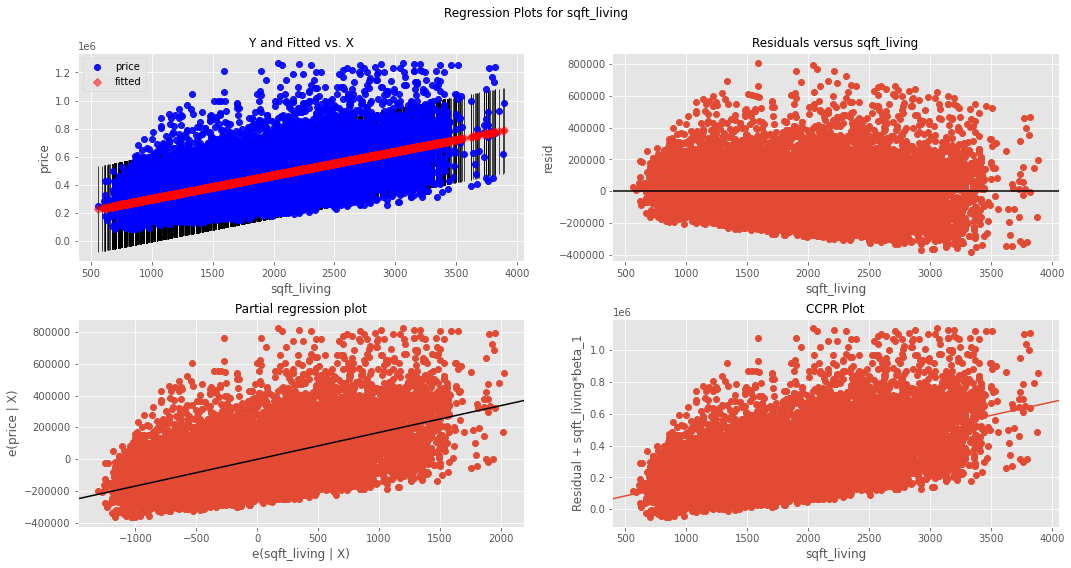

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     5840.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        03:41:35   Log-Likelihood:            -1.7040e+05
No. Observations:               12742   AIC:                         3.408e+05
Df Residuals:                   12740   BIC:                         3.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.322e+05   4336.163     30.493      

In [541]:
ols_and_error_vis(df=slr_df, x="sqft_lot", y="price", xs=slr_df["sqft_lot"], ys=slr_df["price"]) 

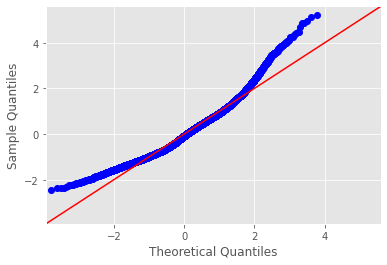

In [542]:
qqplot(df=slr_df, x="sqft_lot", y="price", xs=slr_df["sqft_lot"], ys=slr_df["price"]) 

In [543]:
test(df=slr_df, x="sqft_lot", y="price", xs=slr_df["sqft_lot"], ys=slr_df["price"])

TypeError: 'DataFrame' object is not callable

## Price Vs Condtion



Slope: 355430.6


Best Fit: 355430.6 -728189.39


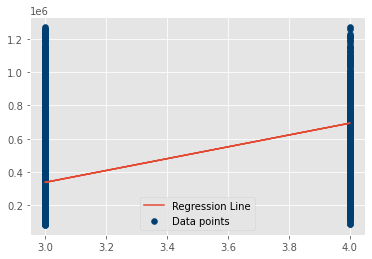

In [546]:
plot_regression(df=slr_df, x="condition", y="price", xs=slr_df["condition"], ys=slr_df["price"])

In [545]:
slr_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2
6,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,0.0,1995,0.0,98003,47.3097,-122.327,2238,6819,6
8,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,1180,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265,2
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,2
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,6
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,1


## Reference 

In [499]:
slr_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [ ]:
plot_regression(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"])
kde(slr_df['sqft_living'])
ols_and_error_vis(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"]) 
qqplot(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"]) 
test(df=slr_df, x="sqft_living", y="price", xs=slr_df["sqft_living"], ys=slr_df["price"])

In [ ]:
Functions List:
plot_regression(df, x, y, xs, ys)
kde(xs)
ols_and_error_vis(df, x, y, xs, ys) 
qqplot(df, x, y, xs, ys) 
test(df, x, y, xs, ys):